<a href="https://colab.research.google.com/github/s1173652/ProgrammingAssignment1/blob/main/HW9_ProjectSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.ml.classification import LogisticRegression
# please download 'ratings.csv' from week 12 on canvas
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('recommend-ML').getOrCreate()
df = spark.read.csv('ratings.csv', header = True, inferSchema = True)
cols = df.columns
df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- recommendation: string (nullable = true)
 |-- album: integer (nullable = true)
 |-- artist: integer (nullable = true)
 |-- num_genre_ratings: integer (nullable = true)
 |-- max: integer (nullable = true)
 |-- min: integer (nullable = true)
 |-- mean: double (nullable = true)
 |-- variance: double (nullable = true)
 |-- median: integer (nullable = true)



In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [ ]:
numericCols = ['album', 'artist', 'num_genre_ratings', 'max', 'min', 'mean', 'variance', 'median']
stages = []
assemblerInputs =  numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
label_stringIdx = StringIndexer(inputCol = 'recommendation', outputCol = 'label')
stages += [label_stringIdx]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- recommendation: string (nullable = true)
 |-- album: integer (nullable = true)
 |-- artist: integer (nullable = true)
 |-- num_genre_ratings: integer (nullable = true)
 |-- max: integer (nullable = true)
 |-- min: integer (nullable = true)
 |-- mean: double (nullable = true)
 |-- variance: double (nullable = true)
 |-- median: integer (nullable = true)



In [ ]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,1.0,0.0,0.0
features,"[72.0, 35.0, 6.0, 148.0, 0.0, 33.6, 0.627, 50.0]","[66.0, 29.0, 1.0, 85.0, 0.0, 26.6, 0.351, 31.0]","[40.0, 35.0, 0.0, 137.0, 168.0, 43.1, 2.288, 3...","[64.0, 0.0, 8.0, 183.0, 0.0, 23.3, 0.672, 32.0]","[66.0, 23.0, 1.0, 89.0, 94.0, 28.1, 0.167, 21.0]"
userID,200031,200031,200031,200031,200031
trackID,30877,8244,34503,130183,198762
recommendation,yes,yes,yes,no,no
album,72,66,40,64,66
artist,35,29,35,0,23
num_genre_ratings,6,1,0,8,1
max,148,85,137,183,89
min,0,0,168,0,94


In [ ]:
# we split the last 76 users X 6 tracks = 468 records as the training
# the first 50 users X 6 tracks = 300 records as the testing
train = df.where(col("userID").between(200596, 201720))
test = df.where(col("userID").between(200031, 200563))
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 468
Test Dataset Count: 300


In [ ]:
# logistic regression in pySpark
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=3)
lrModel = lr.fit(train)

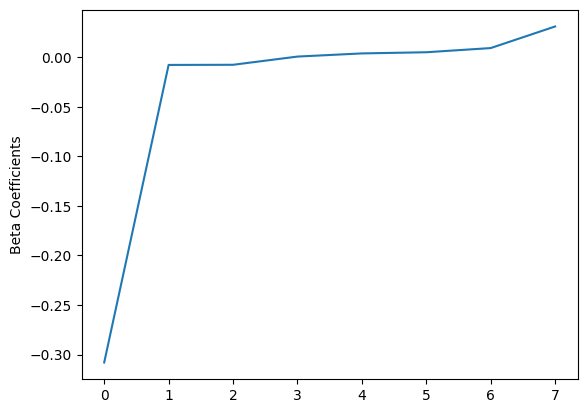

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

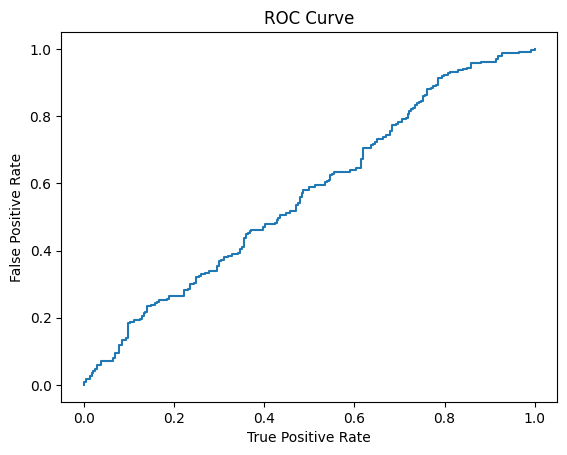

Training set areaUnderROC: 0.565983636496457


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
predictions = lrModel.transform(test)
predictions.select('userID', 'trackID', 'label', 'probability',
                   'rawPrediction', 'prediction' ).show(12)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031|  30877|  1.0|[0.49780118409754...|[-0.0087953203081...|       1.0|
|200031|   8244|  1.0|[0.55448314345773...|[0.21880132324172...|       0.0|
|200031|  34503|  1.0|[0.53555038969029...|[0.14244191305826...|       0.0|
|200031| 130183|  0.0|[0.47073161773969...|[-0.1172075241770...|       1.0|
|200031| 198762|  0.0|[0.50318268623581...|[0.01273091688875...|       0.0|
|200031| 227283|  0.0|[0.53390504652243...|[0.13582863145187...|       0.0|
|200032|  18681|  1.0|[0.33961538265747...|[-0.6650086690234...|       1.0|
|200032| 138493|  1.0|[0.64666669876599...|[0.60441920543654...|       0.0|
|200032|  64167|  1.0|[0.55241387842743...|[0.21042857545233...|       0.0|
|200032| 218377|  0.0|[0.46714767918523...|[-0.1315988769347...|       1.0|
|200032| 110

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031|   8244|  1.0|[0.55448314345773...|[0.21880132324172...|       0.0|
|200031|  34503|  1.0|[0.53555038969029...|[0.14244191305826...|       0.0|
|200031| 227283|  0.0|[0.53390504652243...|[0.13582863145187...|       0.0|
|200031| 198762|  0.0|[0.50318268623581...|[0.01273091688875...|       0.0|
|200031|  30877|  1.0|[0.49780118409754...|[-0.0087953203081...|       1.0|
|200031| 130183|  0.0|[0.47073161773969...|[-0.1172075241770...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
# decision tree classifier in pySpark

from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label',maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
sort_predictions = predictions.select('userID', 'trackID',
                   'label', 'probability',
                   'rawPrediction', 'prediction' ).sort(col("userID").asc(), col("probability").desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+-------------+----------+
|userID|trackID|label|         probability|rawPrediction|prediction|
+------+-------+-----+--------------------+-------------+----------+
|200031|  30877|  1.0|[0.63235294117647...|  [43.0,25.0]|       0.0|
|200031|   8244|  1.0|[0.43956043956043...|  [40.0,51.0]|       1.0|
|200031| 198762|  0.0|[0.43956043956043...|  [40.0,51.0]|       1.0|
|200031|  34503|  1.0|[0.42570281124497...|[106.0,143.0]|       1.0|
|200031| 130183|  0.0|[0.42570281124497...|[106.0,143.0]|       1.0|
|200031| 227283|  0.0|[0.42570281124497...|[106.0,143.0]|       1.0|
+------+-------+-----+--------------------+-------------+----------+
only showing top 6 rows



In [ ]:
# random forest classifier in pySpark

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
sort_predictions = predictions.select('userID', 'trackID',
                   'label', 'probability',
                   'rawPrediction', 'prediction' ).sort(col("userID").asc(), col("probability").desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.54362040499492...|[10.8724080998985...|       0.0|
|200031|  30877|  1.0|[0.53002184832900...|[10.6004369665800...|       0.0|
|200031| 227283|  0.0|[0.52761509439560...|[10.5523018879121...|       0.0|
|200031|   8244|  1.0|[0.41083412674424...|[8.21668253488486...|       1.0|
|200031|  34503|  1.0|[0.37640300261623...|[7.52806005232475...|       1.0|
|200031| 198762|  0.0|[0.36969907096539...|[7.39398141930799...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
# Gradient-Boosted Tree Classifier

from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
sort_predictions = predictions.select('userID', 'trackID',
                   'label', 'probability',
                   'rawPrediction', 'prediction' ).sort(col("userID").asc(), col("probability").desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031|  30877|  1.0|[0.52917232203789...|[0.05841098324244...|       0.0|
|200031| 227283|  0.0|[0.46256860871825...|[-0.0750031093011...|       1.0|
|200031| 198762|  0.0|[0.43072480054328...|[-0.1394472997190...|       1.0|
|200031| 130183|  0.0|[0.41254384931646...|[-0.1767295523000...|       1.0|
|200031|   8244|  1.0|[0.30000446137460...|[-0.4236383079182...|       1.0|
|200031|  34503|  1.0|[0.16256856228697...|[-0.8196197801894...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows

